Gaussian Processes - Submission Notebook
========================================



## Gaussian Processes



This notebook will form part of your individual submission for the course. The notebook will roughly mimick the parts that are in the `PDF` worksheet. Your task is to complete the code that is missing in the parts below and answer the questions that we ask. The aim is **not** for you to **solve** (I'm not actually sure what that means) the worksheet but rather for you to show your understanding of the material in the course, instead of re-running and aiming to get "perfect" results run things, make sure it is correct and then try to explain your results with a few sentences. Actually if it is not correct and you explain things well that might actually teach you more things.

We are going to work with GPs in exactly the same setting as in the case of linear regression. This means we are interested in the task of observing a data-set $\mathcal{D} = \{x_i, y_i \}_{i=1}^N$ where we assume the following relationship between the variates,  
$$
y_i = f(x_i).
$$
Our task is to infer the function $f(\cdot$) from $\mathcal{D}$. We will make the same assumptions of independence as in the linear regression case which leads us to the following likelihood function,
$$
p(\mathbf{y}\vert f(\mathbf{x})) = \prod_{i=1}^N p(y_i \vert f(x_i)),
$$
where $f(x_i)$ is the output of the function at location $x_i$.

**Question 1**
Explain what the independence assumption implies? How would the likelihood look if we could not make this assumption?

**Answer**
Under the independence assumption, we believe (assume) that the observational noise is independent of the location at which the value was observed: Given an observation $y_i$ for some input $x_i$, the amount of corruption (noise) relative to the *""true""*[^1] value of $f(x_i)$ can be represented by a variable $\epsilon$ following some *constant* distribution.[^2] In general,[^3] we often take this to mean that the observed value $y_i$ is corrupted by additive noise such that $y_i = f(x_i) + \epsilon$, where $\epsilon$ is sampled from the noise distribution. That is, the observed values/distribution of $\epsilon$ is (assumed to be) independent to the value of $x_i$: Given many samples of $f(\cdot)$ for any two inputs $x_i$ and $x_j$, the observed distributions of $\epsilon$ at $x_i$ and $x_j$ are the same.

As a relevant example, in the case of homogenous noise, this would be to specify/assume that the precision $\beta^{-1}$ is constant.

[^1]: Or as close to a "true" value as makes sense depending on the context.
[^2]: For example, the Gaussian distribution, such that $\epsilon\sim\mathcal{N}(0,\beta^{-1})$ where $\beta^{-1}$ is the precision of the noise. This is homogenous noise.
[^3]: I note this as "in general" because specifying the noise as additive is its own distinct assumption. However,
this is very often true or close enough to reality as to be a reasonable approximation. Alternatively, it may instead be the case that the noise is multiplicative (or some other operand) instead. The important thing with the independence assumption is that the nature of how the noise impacts the observation is *not* itself defined by some *other* function on $x$. That is, it is *not* the case that $\epsilon$ can/must be computed as $\epsilon = g(x)$, where $g(x)$ is some function defining the behavior of the noise with respect to $x$ (unless $g(x)$ is itself independent of $x$, but at that point $g(\cdot)$ need not be parameterized by $x$ in the first place).

Now lets get our hands dirty and do some implementation so lets import some basic libraries that we are going to need for the lab. We will also set the random number seed.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

### Prior



We will now proceed to define the prior over the function values $p(\mathbf{f})$, we will do so using a Gaussian process. The prior being non-parametric needs in addition to a set of parameters $\boldsymbol{\theta}$ also access to the location where we want to evaluate it $\mathbf{x}$. This means the distribution that we are going to parametrise is,
$$
p(\mathbf{f}\mid \mathbf{x},\boldsymbol{\theta}) = \mathcal{N}\left(\mathbf{f}\mid \mu(\mathbf{x}, k(\mathbf{x},\mathbf{x}) \right).
$$
We will begin by implementing the co-variance function $k(x_i,x_j)$. We will play around with



In [3]:
def rbf_kernel(x1, x2, varSigma, lengthscale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)

    K = varSigma*np.exp(-np.power(d, 2)/lengthscale)

    return K

def lin_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*x1.dot(x1.T)
    else:
        return varSigma*x1.dot(x2.T)
    
def white_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*np.eye(x1.shape[0])
    else:
        return np.zeros(x1.shape[0], x2.shape[0])
    
def periodic_kernel(x1, x2, varSigma, period, lengthScale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return varSigma*np.exp(-(2*np.sin((np.pi/period)*d)**2)/lengthScale**2)

**Question 2** Evaluate the four covariance functions implemented above for a one dimensional index set, say `x = np.linspace(-6,6,100).reshape(-1,1)` and plot the result using `plt.imshow()`. Play around with the input parameters to the co-variance functions to make sure you have an idea of what they do and how the alter the matrix. **Explain briefly why the matrices look the way they do and what it will imply for which functions we find likely.**

rbf


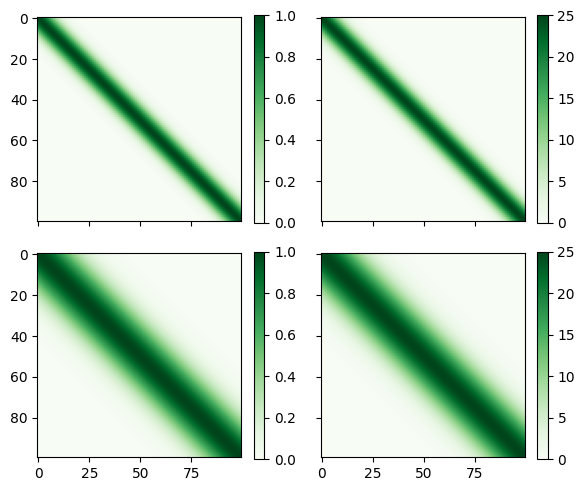

linear


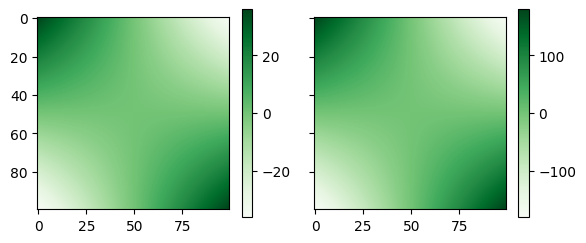

white noise


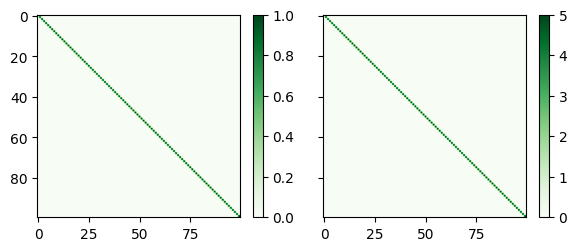

periodic


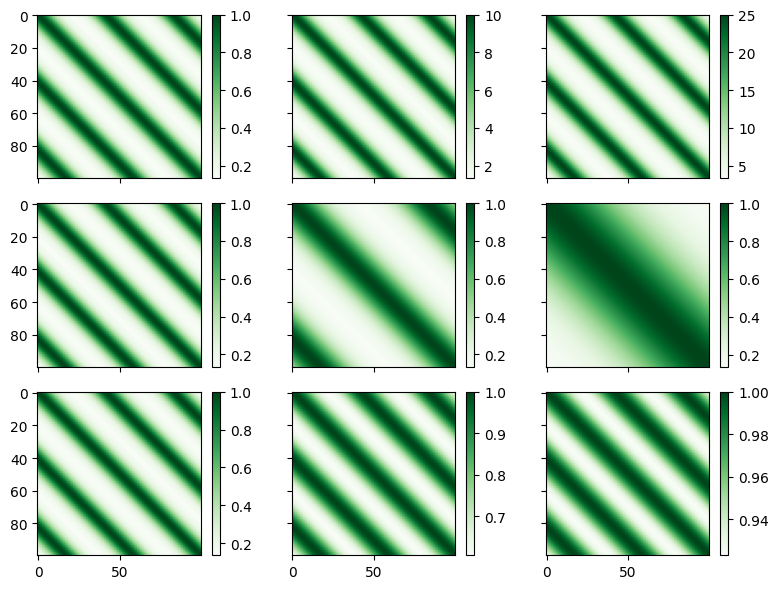

In [7]:
x = np.linspace(-6,6,100).reshape(-1,1)

print('rbf')
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6,5))

pos = axs[0,0].imshow(rbf_kernel(x, None, 1, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[0,0])
pos = axs[0,1].imshow(rbf_kernel(x, None, 25, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[0,1])
pos = axs[1,0].imshow(rbf_kernel(x, None, 1, 5), cmap='Greens')
fig.colorbar(pos, ax=axs[1,0])
pos = axs[1,1].imshow(rbf_kernel(x, None, 25, 5), cmap='Greens')
fig.colorbar(pos, ax=axs[1,1])

plt.tight_layout()
plt.show()


print('linear')
_, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,2.5))

pos = axs[0].imshow(lin_kernel(x, None, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(lin_kernel(x, None, 5), cmap='Greens')
fig.colorbar(pos, ax=axs[1])

plt.tight_layout()
plt.show()


print('white noise')
_, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6,2.5))

pos = axs[0].imshow(white_kernel(x, None, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(white_kernel(x, None, 5), cmap='Greens')
fig.colorbar(pos, ax=axs[1])

plt.tight_layout()
plt.show()


print('periodic')
_, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,6))

pos = axs[0,0].imshow(periodic_kernel(x, None, 1, 5, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[0,0])
pos = axs[0,1].imshow(periodic_kernel(x, None, 10, 5, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[0,1])
pos = axs[0,2].imshow(periodic_kernel(x, None, 25, 5, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[0,2])
pos = axs[1,0].imshow(periodic_kernel(x, None, 1, 5, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[1,0])
pos = axs[1,1].imshow(periodic_kernel(x, None, 1, 10, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[1,1])
pos = axs[1,2].imshow(periodic_kernel(x, None, 1, 25, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[1,2])
pos = axs[2,0].imshow(periodic_kernel(x, None, 1, 5, 1), cmap='Greens')
fig.colorbar(pos, ax=axs[2,0])
pos = axs[2,1].imshow(periodic_kernel(x, None, 1, 5, 2), cmap='Greens')
fig.colorbar(pos, ax=axs[2,1])
pos = axs[2,2].imshow(periodic_kernel(x, None, 1, 5, 5), cmap='Greens')
fig.colorbar(pos, ax=axs[2,2])

plt.tight_layout()
plt.show()

**Answer**



Now when we have implemented the co-variance function we can generate samples from the prior. We can use the function `np.random.multivariate_normal()` in order to sample points from a multi-variate Gaussian. We will use a zero-mean process so the mean function is just constant $0$.

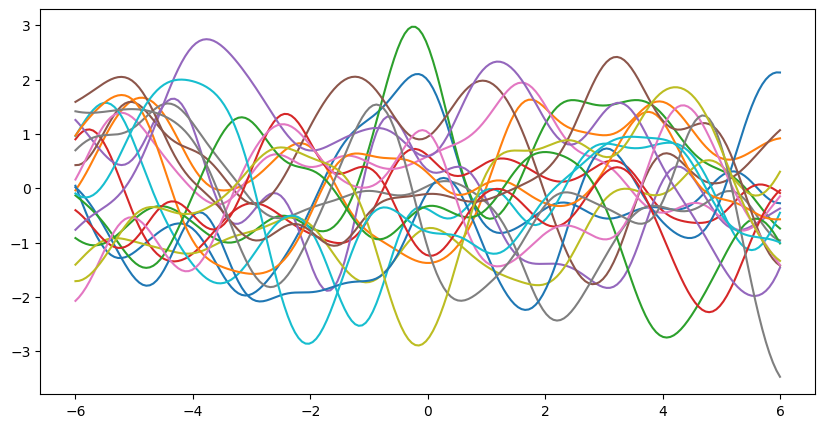

In [11]:
x = np.linspace(-6,6,200).reshape(-1,1)
K = rbf_kernel(x,x,1,1)
mu = np.zeros(x.shape)

f = np.random.multivariate_normal(mu.flatten(), K, 20)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(x, f.T)
plt.show()

Play around a little bit with the parameters of the co-variance function and generate samples. Try to build up a notion of how the samples are controlled by the parametrisation. Make sure that you can get the connection between the co-variance matrix that we visualised and the samples that you see.

**Question 3** So far we have used a mean function that is constant zero. Try to use a different type of mean-function, first try with a linear-linear function (i.e. a line) and then try a periodic function like a sine. Explain the effect that the mean function have on the samples that you draw.n

**Answer**

One interesting thing about co-variance functions are that they are closed under lots of operations. This means that you can combine them in different ways. Try to generate samples from a process where your prior is the `sum` the `product` of several of these functions. Experiment with this a bit, here is where you can input a lot of knowledge into the system.



### Posterior



Now when we have seen samples from the prior it is time to merge these assumptions with observed data. The first thing we will do is to generate some data in a way that we allow us to test things. We will generate two data-sets, a one-dimensional and a two-dimensional function.



In [1]:
def data_1d(N, noise):
    x = np.random.randn(N)
    x = np.sort(x)
    y = -(-np.sin(3*x) - x**2 + 0.7*x) + noise*np.random.randn(x.shape[0])

    return x,y


def data_2d(N, noise):
    xg = np.linspace(-4,4,N)
    x1, x2 = np.meshgrid(xg,xg)
    x1 = x1.flatten()
    x2 = x2.flatten()

    y = (x1**2+x2-11)**2 + (x1+x2**2-7)**2

    X = np.stack((x1,x2)).T
    
    return X, y

Now when we have some data we will get our updated belief about the function values given the prior assumptions and the data we have observed. To do so we need to formulate the predictive distribution of the Gaussian process.

**Question 4** Explain how we reach the updated belief about our function given the data? What is the specific process that we have to go through? Explain this both for any general model and what is unique (rather unique actually) about how we do this using a Gaussian process prior?

**Answer**

**Question 5** Now look first at the formulation of the predictive posterior. We can see that the posterior variance consists of two terms, one substracted from the other. Explain what the effect of these two terms are and try to provide an intuition of how it leads to the posterior variance. One good way to do this is to plot each of the terms individually. 

Now let us implement the predictive posterior evaluated at data `x1, y1` and evaluated at `xstar`. You might want to be a bit more clever and implement a generic function that takes the matrices as input instead so that you can try different co-variance functions.



In [1]:
def gp_prediction(x1, y1, xstar, lengthScale, varSigma, noise):

	k_starX = rbf_kernel(xstar,x1,lengthScale,varSigma,noise)
	k_xx = rbf_kernel(x1, None, lengthScale, varSigma, noise)
	k_starstar = rbf_kernel(xstar,None,lengthScale,varSigma,noise)

	mu = k_starX.dot(np.linalg.inv(k_xx)).dot(y1)
	var = k_starstar - (k_starX).dot(np.linalg.inv(k_xx)).dot(k_starX.T)

	return mu, var, xstar

**Question 6** Using the function above, generate samples using the one-dimensional data. Then generate a plot where you show the mean and the marginal variance at each function evaluation. You can generate the plots that you have seen in the lectures using `np.fill_between()`.

**Answer**



In [1]:
#generate the plots

In the final step covering the material that we have covered in the lectures we are now going to include the likelihood function that we first specified and write down the predictive posterior. This alters the posterior to the one below if we have a likelihood with precision $\beta$.

\begin{align}
p(\mathbf{f}_*\vert \mathbf{y}, \mathbf{x},\mathbf{x}_*,\theta) &= \mathcal{N}(\mu_{\mathbf{x}_*\vert \mathbf{x}}, K_{\mathbf{x}_*\vert \mathbf{x}})\\
\mu_{\mathbf{x}_*\vert \mathbf{x}} &= k(\mathbf{x}_*,\mathbf{x})\left(k(\mathbf{x},\mathbf{x})+\frac{1}{\beta}\mathbf{I}\right)^{-1}\mathbf{y}\\
K_{\mathbf{x}_*\vert \mathbf{x}} &= k(\mathbf{x}_*,\mathbf{x}_*) - k(\mathbf{x}_*,\mathbf{x})\left(k(\mathbf{x},\mathbf{x})+\frac{1}{\beta}\mathbf{I}\right)^{-1}k(\mathbf{x},\mathbf{x}_*).
\end{align}

**Question 7** Explain why the predictive posterior changes in the way it does? How does the samples of the function change from when we did not include this term? Think about the concept of "explaining away" that we discussed during the lectures.

**Answer**



### Learning



In this final part we will go a bit beyond the material that we have covered in the lectures. So far we have specified the Gaussian process prior, performed the marginalisation and computed the predictive posterior. In this case the hyper-parameters, the parameters of the co-variance function have been fixed. We will now proceed to optimise the marginal likelihood as a way of "learning" the parameters. This means that our learning task is to,
$$
\hat{\boldsymbol{\theta}} = \operatorname{argmax}_{\boldsymbol{\theta}} p(\mathbf{y}\mid\mathbf{X},\boldsymbol{\theta}).
$$
Now in order to make things a little bit nicer for us to optimise we are instead of looking at the likelihood going to use the negative log-marginal likelihood instead and try to find the parameters that minimises this,
$$
\hat{\boldsymbol{\theta}} = \operatorname{argmin}_{\boldsymbol{\theta}} - \textrm{log}\left( p(\mathbf{y}\mid\mathbf{X},\boldsymbol{\theta})\right) = \mathcal{L}(\boldsymbol{\theta})
$$

**Question 8** Explain why these two objective functions lead to the same optimisation problem?

**Answer**

Now lets write up the log-marginal likelihood,
$$
\operatorname{log} p(\mathbf{y}\mid \mathbf{X}, \boldsymbol{\theta}) = \int p(\mathbf{y}\mid \mathbf{f})p(\mathbf{f}\mid \mathbf{X},\boldsymbol{\theta})\textrm{d}\boldsymbol{\theta}
$$
$$
-\frac{1}{2}\mathbf{y}^{\textrm{T}}\left(k(\mathbf{x},\mathbf{x})\right)^{-1}\mathbf{y} - \frac{1}{2}\operatorname{log}\operatorname{det}\left(k(\mathbf{x},\mathbf{x}-\beta^{-1}\mathbf{I}\right) - \frac{N}{2}\operatorname{log}2\pi = -\mathcal{L}(\boldsymbol{\theta})
$$

We will perform the optimisation using a gradient based optimiser. This means that we need to compute the gradients of the loss-function $\mathcal{L}$ with respect to $\boldsymbol{\theta}$. While these gradients are not very hard to compute by hand, and you are more than free to do so, we can also use packages that can handle `auto-differentiation`. There are lots of them around but my preference is to use `jax` which nicely follows `numpy`. Below is some scaffolding to a simple gradient based optimisation loop.



In [1]:
from jax import grad
import jax.numpy as jnp

def squared_exponential(x1, x2, theta):
    # theta[0] - variance
    # theta[1] - lengthscale
    # theta[2] - noise variance
    if x2 == None:
        return theta[0]*jnp.exp(-cdist(x1, x1, metric='sqeuclidean')/theta[1]**2) + (1/theta[2])*jnp.eye(x.shape[0])
    else:
        return theta[0]*jnp.exp(-cdist(x1, x2, metric='sqeuclidean')/theta[1]**2)

def logmarginal_likelihood(x, y, theta):
    # implement the log-marginal likelihood of a GP
    
dLdtheta = grad(logmarginal_likelihood, argnums=3)
for i in range(1000):
    
    theta -= dLdtheta(theta) * 0.01

Finish the code above and try to learn the hyper-parameters given a set of observed data. You might want to use data that is quite noisy and where you do not have too many data-points to avoid some computational issues that might emerge. If you are finding that the optimisation somehow crashes, try to remove `theta[2]` from the optimisation and make it a fixed value.

**Question 9** Show a plot where you show both the predictive posterior of the initial setting (the start values of $\boldsymbol{\theta}$ and the optimised values. Explain the results.

**Answer**

**Question 10** In the co-variance function `def squared_exponential` above we have two linear parameters `theta[0]` and `theta[2]` that scales the two terms of the function. Interpret these two parameters, what does the relation between the two mean? Hint: rather than thinking about precision think about `1/theta[2]` which is related to the variance.

**Answer**



### Submission



Now you are done with this notebook and hopefully you feel that you have a good understanding of Gaussian processes both in theory and in practice. The key thing when we move onto to the next parts of the course is that you start building up an intuition for what you can do with these models, how you can alter things, what assumptions/knowledge that are easy to encode etc. Please submit your notebook on Moodle before the deadline which is **Friday 20th of October 12:00**

